# Predicting fuel consumption

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


Escolha uma base de dados pública que represente um problema supervisionado de classificação ou de regressão e utilizando uma rede neural MLP de uma camada oculta:

1. escreva uma rotina que carrega a base de dados e realiza o treinamento da MLP com validação cruzada k-fold (utilize bibliotecas de aprendizado de máquina e k=5).
2. varie o número de neurônios da camada oculta buscando o melhor resultado de treinamento utilizando o algoritmo Backpropagation:
  * realize 5 inicializações do treinamento e exiba os resultados considerando o valor médio e o desvio padrão;
  * a depender do problema escolhido, o parâmetro de avaliação do desempenho pode mudar, justifique a escolha do parâmetro utilizado;
  * analise as curvas de treinamento -> em algum caso houve overfitting? Justifique.
3. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando parâmetros do algoritmo de treinamento como: tamanho da batelada e taxa de aprendizagem.
4. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando o algoritmo de treinamento para Levemberg-Marquardt e R-PROP.

In [2]:
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# auto_mpg = fetch_ucirepo(id=9)

# # data (as pandas dataframes)
# X = auto_mpg.data.features
# y = auto_mpg.data.targets

# # metadata
# print(auto_mpg.metadata)

# # variable information
# print(auto_mpg.variables)


## Getting data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\darth\\.keras\\datasets\\auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

full_dataset = raw_dataset.copy()
full_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Cleaning data

In [5]:
full_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
full_dataset = full_dataset.dropna()

In [7]:
origin = full_dataset.pop('Origin')
full_dataset['USA'] = (origin == 1)*1.0
full_dataset['Europe'] = (origin == 2)*1.0
full_dataset['Japan'] = (origin == 3)*1.0
full_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Separating data

In [8]:
# train_dataset = dataset.sample(frac=0.8,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

Analyzing distribution of data.

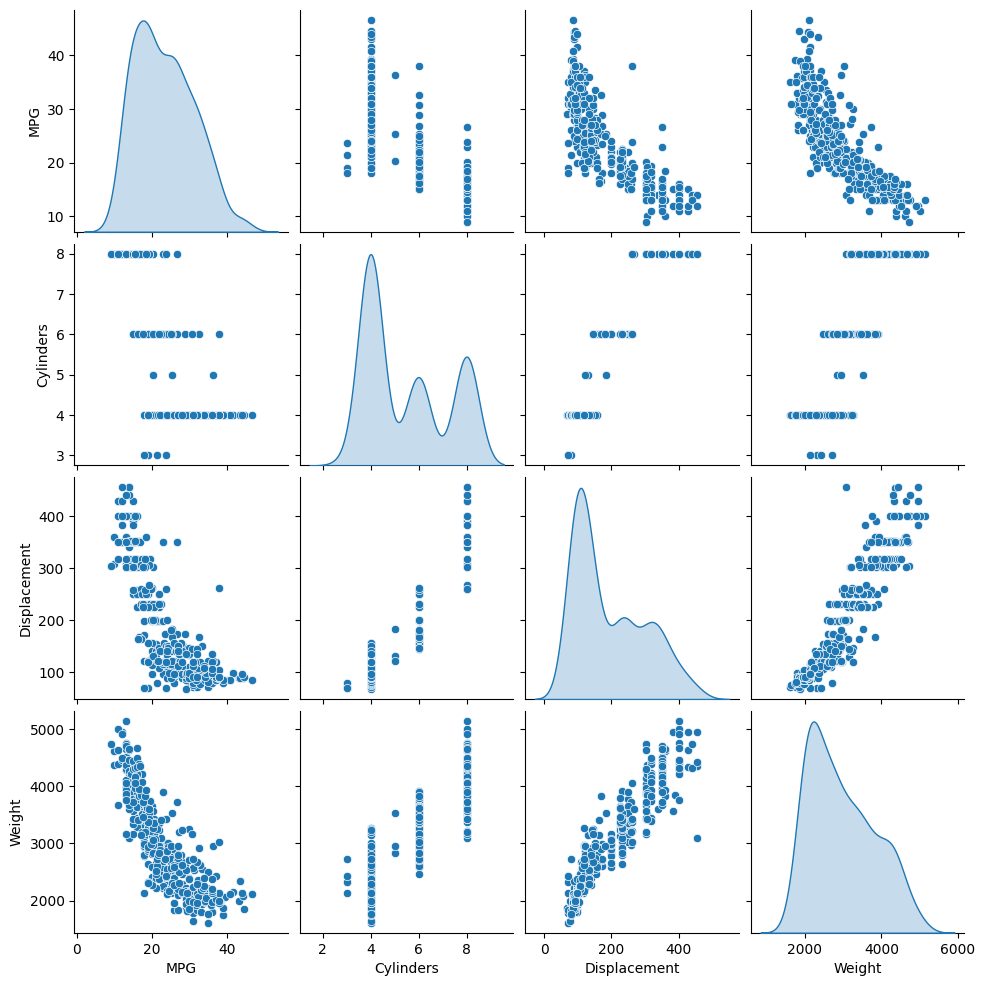

In [9]:
sns.pairplot(full_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
X = full_dataset
y = X.pop('MPG')

In [11]:
stats = X.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.0,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.0,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.5,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.5,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.0,79.000,82.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.0,1.000,1.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.0,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.0,0.000,1.0


In [12]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose
  mean = stats['mean']
  std = stats['std']

  return (x - mean) / std

# normed_train_data = norm(dataset)

## Model

In [13]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [14]:
def get_model(neurons=10, input_shape=None):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(neurons, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='Adam',
                  loss="mse",
                  metrics=['mae', r2_metric])
    return model

## Cross validation KFold

In [15]:
from sklearn.model_selection import LeaveOneOut, KFold
from tensorflow.python.data import Iterator

In [16]:
def make_dataset(X_data, y_data, n_splits):
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            # Use `.iloc` se X_data ou y_data forem pandas DataFrame/Series
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
            y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            yield X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

    return tf.data.Dataset.from_generator(gen, (tf.float64, tf.float64, tf.float64, tf.float64))


dataset = make_dataset(X, y, 5)
dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [17]:
type(dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [18]:
for fold, (X_train, y_train, X_test, y_test) in enumerate(dataset):
    print(f"Fold {fold + 1}:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print()

Fold 1:
  X_train shape: (313, 9), y_train shape: (313,)
  X_test shape: (79, 9), y_test shape: (79,)

Fold 2:
  X_train shape: (313, 9), y_train shape: (313,)
  X_test shape: (79, 9), y_test shape: (79,)

Fold 3:
  X_train shape: (314, 9), y_train shape: (314,)
  X_test shape: (78, 9), y_test shape: (78,)

Fold 4:
  X_train shape: (314, 9), y_train shape: (314,)
  X_test shape: (78, 9), y_test shape: (78,)

Fold 5:
  X_train shape: (314, 9), y_train shape: (314,)
  X_test shape: (78, 9), y_test shape: (78,)



## Training

In [ ]:
models_hist = {}

for fold, (X_train, y_train, X_test, y_test) in enumerate(dataset):
    input_shape = X_train.shape[1:]  # Exclude the batch size

    model = get_model(input_shape=input_shape)
    print(f"Training fold number {fold}.")
    hist = model.fit(
        x=X_train, y=y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        verbose=0
    )

    models_hist[f'model_{fold}'] = hist




Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


In [20]:
print("We will visualize:", list(models_hist['model_0'].history.keys()))

We will visualize: ['loss', 'mae', 'r2_metric', 'val_loss', 'val_mae', 'val_r2_metric']


Plotting all the metrics

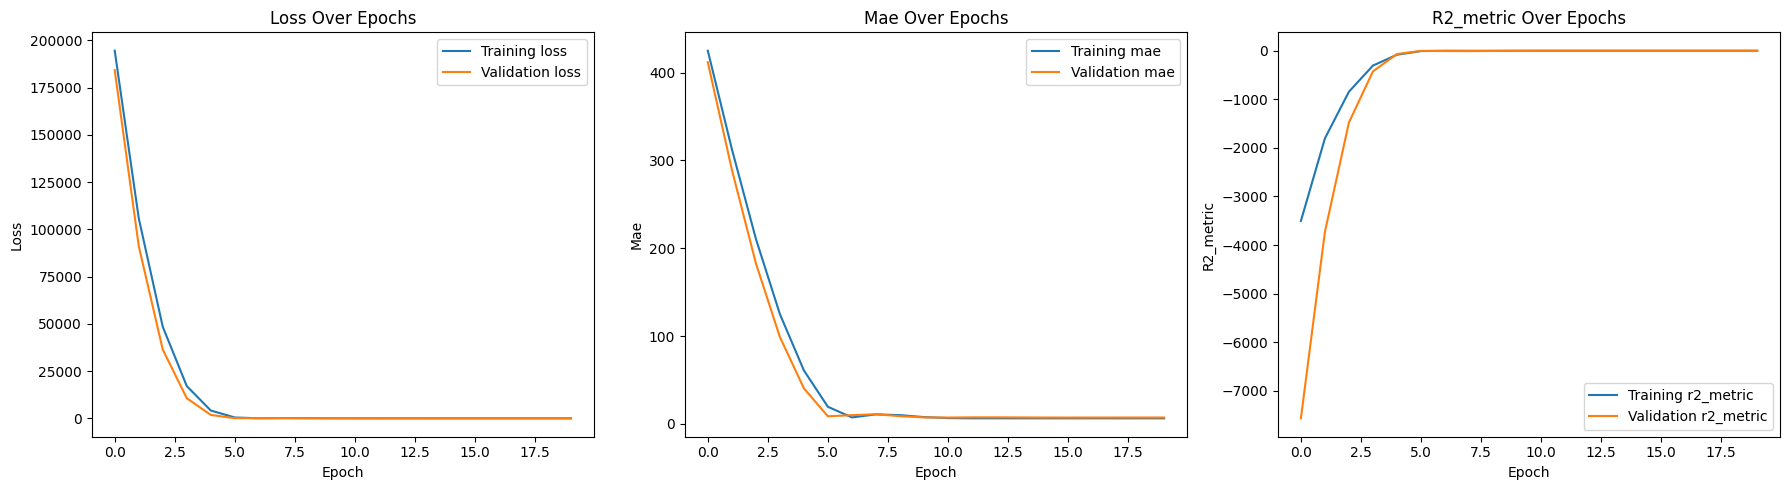

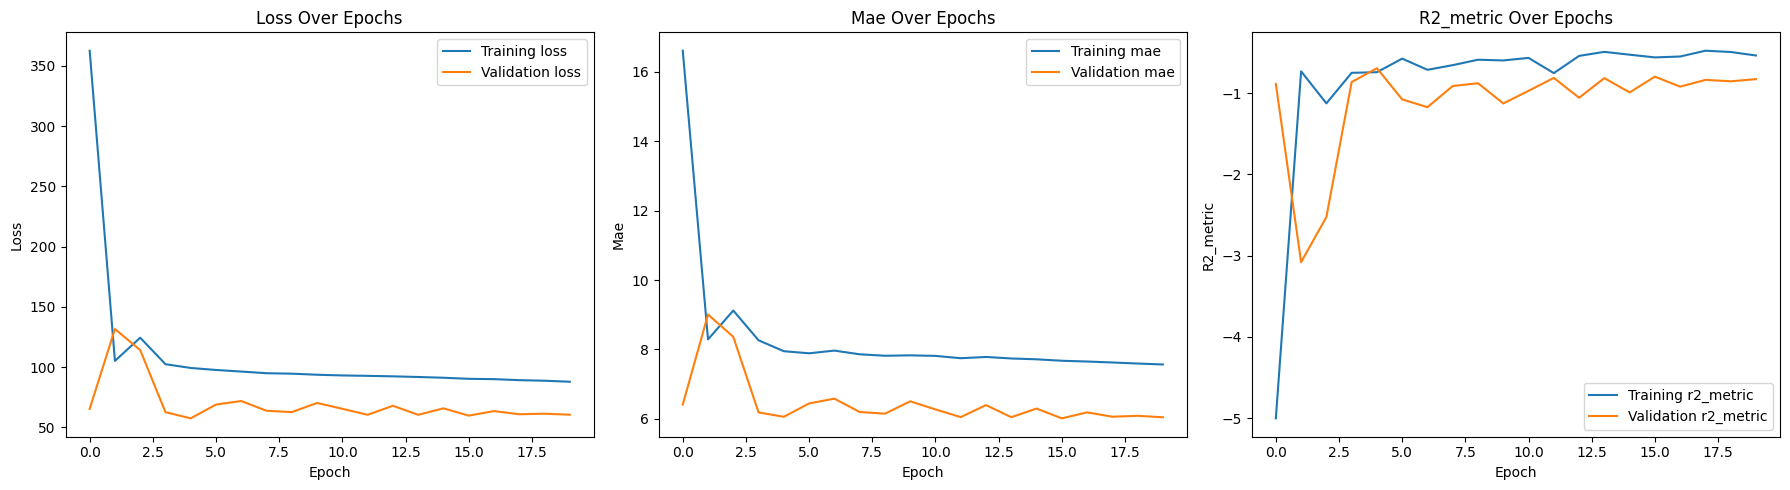

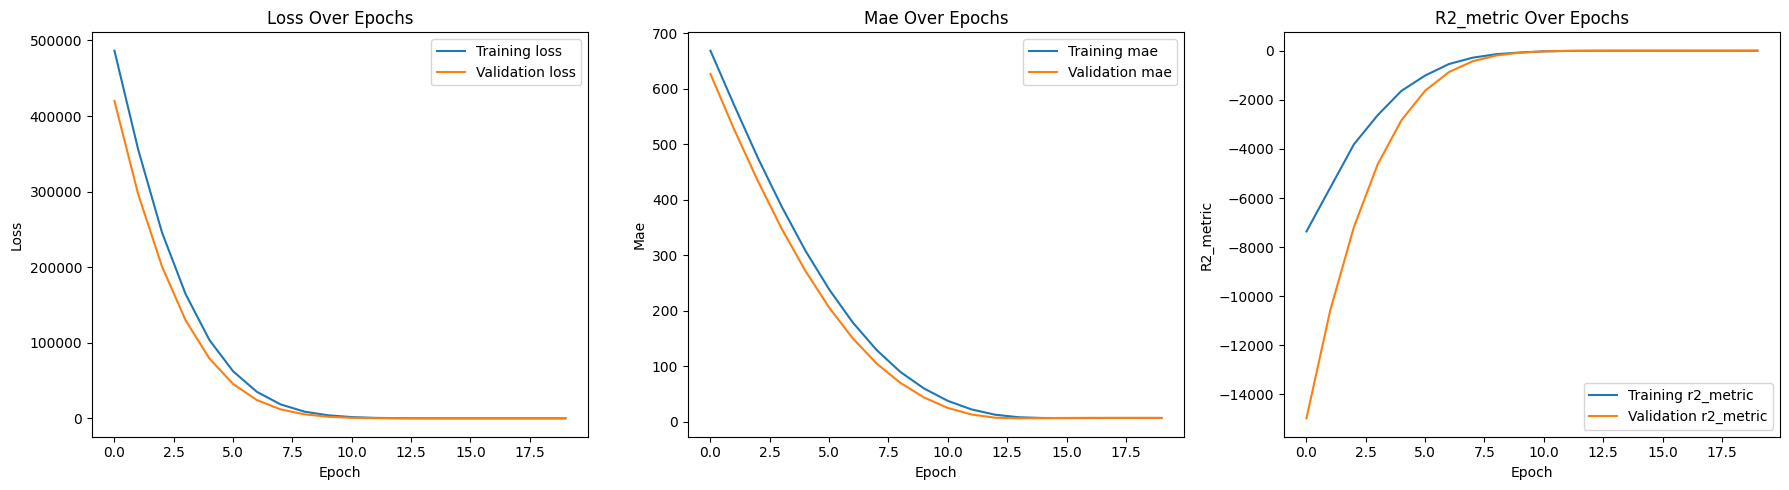

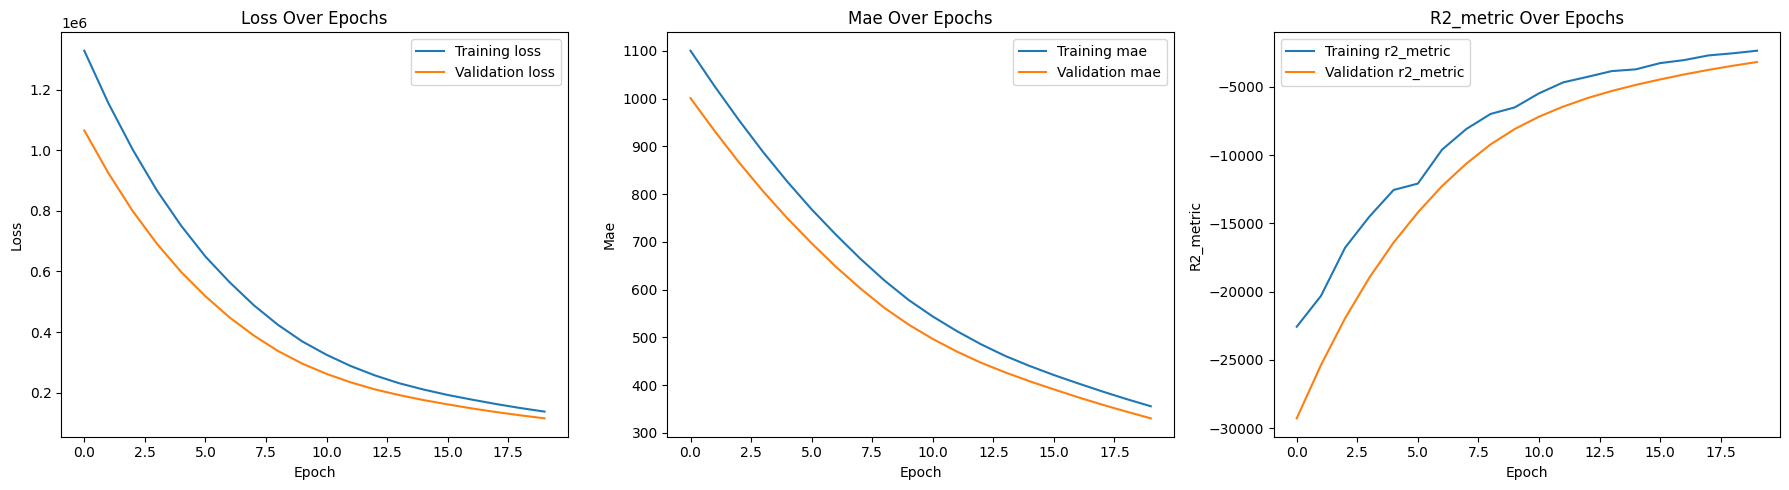

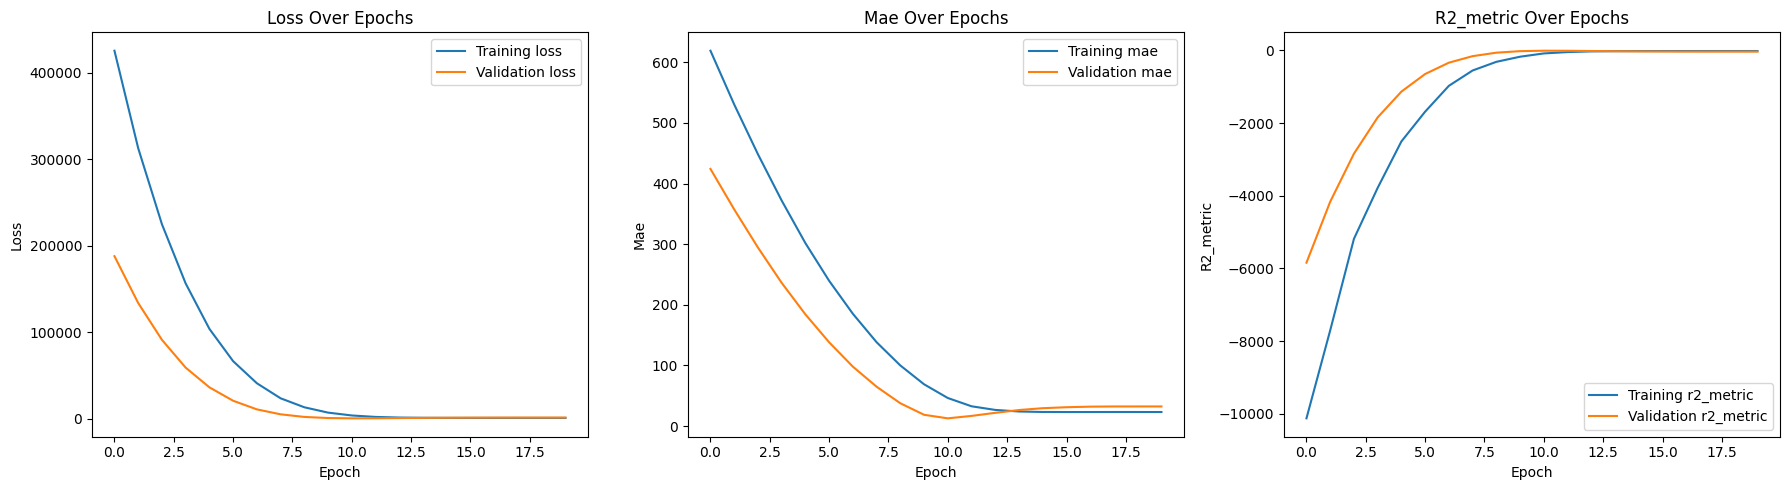

In [21]:
def plot_metrics(history_dict):
    # Separating training and validation metrics
    metrics = [key for key in history_dict.keys() if not key.startswith("val_")]
    val_metrics = ["val_" + metric for metric in metrics]
    
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 5))

    if num_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        sns.lineplot(data=history_dict[metric], label='Training ' + metric, ax=axs[i])
        sns.lineplot(data=history_dict[val_metrics[i]], label='Validation ' + metric, ax=axs[i])

        # Personalize each subplot
        axs[i].set_title(f"{metric.capitalize()} Over Epochs")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()

    plt.tight_layout()
    plt.show()


for history in models_hist:
    history_dict = models_hist[history].history
    plot_metrics(history_dict)